In [36]:
import pandas as pd
import afqinsight as afq
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split
from groupyr.transform import GroupExtractor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import sklearn.metrics
import matplotlib.pyplot as plt

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer

In [40]:
X, y, groups, feature_names, group_names, subjects, _ = afq.datasets.load_afq_data('../data/raw/age_data', target_cols="Age")

In [41]:
group_extractor = GroupExtractor(select=['fa', 'md'], groups=groups, group_names=group_names)
X = group_extractor.fit_transform(X)

In [42]:
#group_names = [g for g in group_names if g[0] in ['md', 'fa']]
#print(len(group_names))
#print(X.shape)
#groups = groups[0:40]
#group_extractor = GroupExtractor(select=['Right Cingulum Cingulate'], groups=groups, group_names=group_names)
#X = group_extractor.fit_transform(X)

In [43]:
X.shape

(77, 4000)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [45]:
imp = SimpleImputer(strategy='median')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

In [46]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((57, 4000), (57,), (20, 4000), (20,))

In [47]:
X_train_reshaped = np.swapaxes(X_train.reshape((57, 40, 100)), 1, 2)
X_test_reshaped = np.swapaxes(X_test.reshape((20, 40, 100)), 1, 2)

In [72]:
basic_model = Sequential()

# input: 3+D tensor with shape: batch_shape + (steps, input_dim)
# output: 3+D tensor with shape: batch_shape + (new_steps, filters) steps value might have changed due to padding or strides.
basic_model = Sequential()
basic_model.add(Dense(128, activation='relu', input_shape=X_train_reshaped.shape[1:]))
basic_model.add(Conv1D(24, kernel_size=2, activation='relu'))
basic_model.add(MaxPool1D(pool_size=2,padding='same'))
basic_model.add(Conv1D(32, kernel_size=2, activation='relu'))
basic_model.add(MaxPool1D(pool_size=2,padding='same'))
basic_model.add(Conv1D(64, kernel_size=3, activation='relu'))
basic_model.add(MaxPool1D(pool_size=2,padding='same'))
basic_model.add(Conv1D(128, kernel_size=4, activation='relu'))
basic_model.add(MaxPool1D(pool_size=2,padding='same'))
basic_model.add(Conv1D(256, kernel_size=4, activation='relu'))
basic_model.add(MaxPool1D(pool_size=2,padding='same'))
basic_model.add(Dropout(0.25))
basic_model.add(Flatten())
basic_model.add(Dense(128, activation='relu'))
basic_model.add(Dropout(0.25))
basic_model.add(Dense(64, activation='relu'))
basic_model.add(Dense(1, activation='linear'))

basic_model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])

In [73]:
basic_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100, 128)          5248      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 99, 24)            6168      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 50, 24)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 49, 32)            1568      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 25, 32)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 23, 64)            6208      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 12, 64)           

In [74]:
import os.path as op
from tensorflow.keras.callbacks import ModelCheckpoint

weights_path = op.join("train", 'cnn_weights.hdf5')
basic_model_checkpoint_callback = ModelCheckpoint(filepath=weights_path,
                                            monitor='val_loss',
                                            mode='auto',
                                            save_best_only=True,
                                            save_weights_only=True,
                                            verbose=True)

# Fitting basic_model using basic_model checkpoint callback to find best basic_model which is saved to 'weights'
basic_model.fit(X_train_reshaped, y_train, epochs=200, batch_size=100, callbacks=[basic_model_checkpoint_callback], validation_data=(X_test_reshaped, y_test))

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 476.4699 - mean_squared_error: 476.4699 - val_loss: 590.6874 - val_mean_squared_error: 590.6874

Epoch 00001: val_loss improved from inf to 590.68738, saving model to train/cnn_weights.hdf5
Epoch 2/200
1/1 [==============================] - 0s 64ms/step - loss: 472.5941 - mean_squared_error: 472.5941 - val_loss: 583.1332 - val_mean_squared_error: 583.1332

Epoch 00002: val_loss improved from 590.68738 to 583.13318, saving model to train/cnn_weights.hdf5
Epoch 3/200
1/1 [==============================] - 0s 59ms/step - loss: 466.8694 - mean_squared_error: 466.8694 - val_loss: 571.2289 - val_mean_squared_error: 571.2289

Epoch 00003: val_loss improved from 583.13318 to 571.22894, saving model to train/cnn_weights.hdf5
Epoch 4/200
1/1 [==============================] - 0s 60ms/step - loss: 457.6703 - mean_squared_error: 457.6703 - val_loss: 552.4336 - val_mean_squared_error: 552.4336

Epoch 00004: val_loss improved from

In [75]:
basic_model.load_weights(weights_path)

In [76]:
#callback = EarlyStopping(monitor='val_loss', patience=50)
#basic_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=100, validation_data=(X_test_reshaped, y_test))
#loss_and_metrics = basic_model.evaluate(X_test_reshaped, y_test, batch_size=100)
#for name, metric in zip(basic_model.metrics_names, loss_and_metrics):
#    print(name, ":", metric)

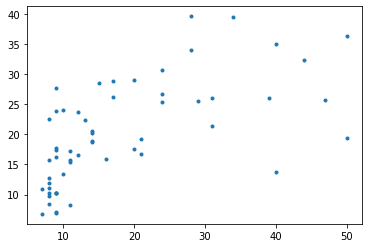

In [77]:
y_hat = basic_model.predict(X_train_reshaped)
plt.plot(y_train, y_hat, linestyle="", marker=".")

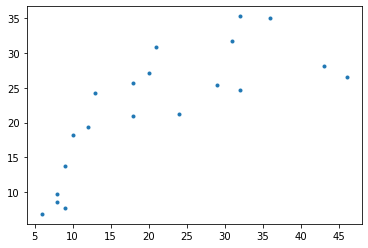

In [78]:
y_hat = basic_model.predict(X_test_reshaped)
plt.plot(y_test, y_hat, linestyle="", marker=".")

In [79]:
from sklearn.metrics import r2_score

In [80]:
r2_score(y_test, y_hat)

0.5888903555226096